# "*Natural climate reconstruction in the Stave Churches through time series processing with variational autoencoders*"

**FFPython2**

Noemi Manara 2022909

Lorenzo Rosset 2021859

Francesco Zambelli 2029014

Andrea Zanola 2027588

In [2]:
!git clone https://github.com/rossetl/Natural-climate-reconstruction-with-VAE.git

fatal: destination path 'Natural-climate-reconstruction-with-VAE' already exists and is not an empty directory.


In [4]:
%cd Natural-climate-reconstruction-with-VAE/data

/content/Natural-climate-reconstruction-with-VAE/data


# **Part 2: Implementation of Variational Autoencoders for the time series reconstruction task**

In the following sections we are going to show some implementations of Variational Autouncoders built in order to reconstruct the hystorical climate of the Ringebu church.

## Theoretical introduction

In the different implementations, we used many layer types, as 1D and 2D Convolutional, 1D and 2D Transpose Convolutional, Dense, both 1D and 2D Max Pooling, Dropout and LSTM.
LSTM and Transposed convolutional in particular are layers we didn't encounter before, so we introduce them with a small theretical description.

### LSTM (Long Short Time Memory)

It's a layer with the charateristics of a Recurrent Neural Network (RNN), which overcomes some difficoulties of the the standard RNN, as the problem of exploding or vanishing gradients realted to the long time information that characterize the considered dateset.

The classical RNN consists in a series of chuncks of neural network which recives as input both the training sample and some information from the previous chuncks. In this way it is possible to implement a sort of "memory", for the fact that some information become rendundand.
Usually the "previous" and "current" information are treated in the same way by the RNN, so in pratice we can often face "short term memory problems", because the further is a piece of information from the current point, the smaller is its influence on the current output.

The LSTM tries to solve this issue.

A LSTM cell appears like this:

![LSTM.png](https://drive.google.com/uc?export=view&id=1DBtdBsmdlR4WisPSDOl36kbFMQihy7ah)

Although it is represented as a chain of blocks (A), it consists of only one block in which we have information recurrence.

The key point is the straight line on the top of the cell, which is called the $\textit{cell state}$. It encapsulates the "long term informations", which are updated with a system of forget-get layers and punctual operations.


![LSTMexpl.png](https://drive.google.com/uc?export=view&id=1ESyCIYFUz4H_SpZPr_5mKghnEUoz77SN)

In the "forget" branch, combining $x_t$ (the current sample information) and $h_{t-1}$ (the hidden information of the previous iteration) the LSTM computes a number between 0 and 1 which tells how much the past information is worth to be kept (0 means to totally erase, 1 to totally keep). Then in the "get" branch, $x_t$ is analyzed in order to check if it contains valuable information or not. Finally this 2 results are combined together in order to create the new $\textit{cell state}$.

With all the previous intermidiate results it is now possibile to calculate the final output of the LSTM, which will both be sent forward in the NN and come back to repeat the iteration as "past information".

![LSTMfin.png](https://drive.google.com/uc?export=view&id=1gVC_-ZGDLL6J105zKSB9dF_OBAWXfGtw)

In this way we can encapsulate in a single value some worthless piece of information that in principle could also go through the entire NN without changing.

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### Convolutional Transpose

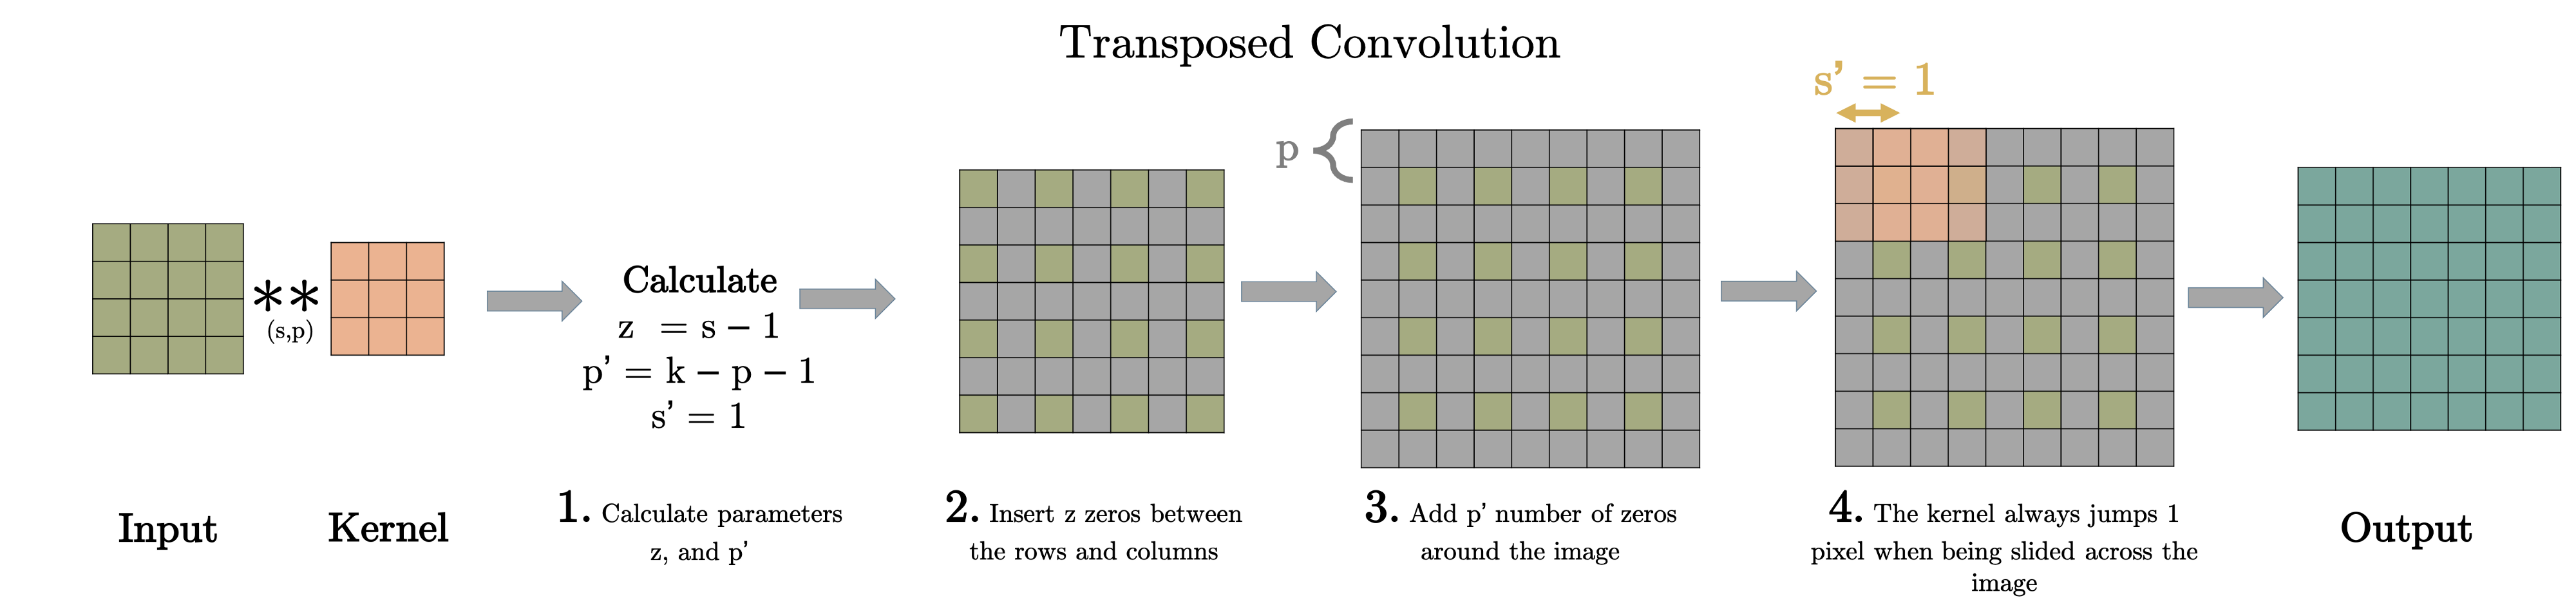

We desired to use a transformation going in the opposite direction of a normal convolution for the decoder of the VAE, and this came as the natural choice. Convolutional Transpose (or Deconvolutional) layers are standard convolutions but with a modified input feature map: first, the input is padded, this time not only along the margins, but also between every single input value, so that the image size is augmented. Then a kernel is applied to this augmented image with stride 1. The resulting output image is so the result of a Convolutional applied to a upsampled image.
In the end, the idea behind transposed convolution is to carry out trainable upsampling.

(https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11)

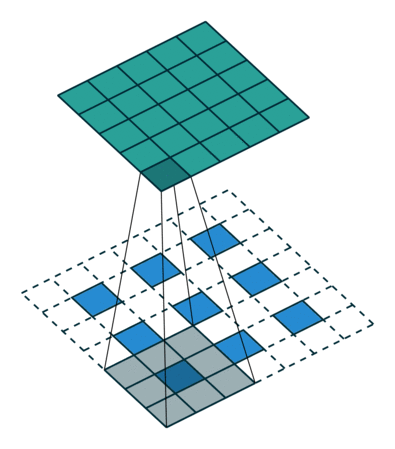

## Libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh as bk
from bokeh.plotting import figure, show
import tensorflow as tf
import time
import math
import keras
from keras import layers, Sequential, regularizers
from keras import backend as K
from IPython import display
import seaborn as sns
bk.io.output_notebook()

from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

## VAE: implementation

### Custom sampling layer for z

Implementation of the reparametrization trick.

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Custom class for the VAE

The total error of the NN composing the VAE is characterized by 2 contributions:
* Reconstruction Loss: we use the MS (Mean Squared Error) between the original and the reconstructed sample.
* KL Divergence: weighted with a coefficient beta that has been finetuned in order for the two contributions to both be effective.

Both terms are kept track of so that it is possible to plot their training curve.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.nn.l2_loss(data - reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.beta*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(self.beta*kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def predict(self, data):
        data = data.reshape(-1, n_records, n_features)
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction.numpy().reshape(-1, n_records, n_features)

    def val_loss(self, data):
        test_loss = tf.keras.metrics.MeanSquaredError()
        predictions = self.predict(data)
        test_loss(predictions, data)
        return test_loss.result().numpy()

### Score definition

In order to have a quantitative parameter for the performances of the VAE, we define the **score** as the sum of two independent terms:


*   *gauss_score*: a term that takes into consideration the likelihood of the reconstructed temperatures.

Let $\mathcal{N}(\mu_{Ringebu}, \Sigma^2_{Ringebu})$ be the multivariate normal distribution with $\mu$, $\Sigma$ estimated from the Ringebu internal and external temperature data. 

In order to build a reconstruction error that can be minimized, we take the natural logarithm of the inverse of the distribution.

$$R_{gauss} =  - log(\mathcal{N} (\mu_{Ringebu}, \Sigma^2_{Ringebu})$$

So this estimator gives low weights to pairs($T_{out}$,$T_{in}$) that lie inside the data ellipse region, while high weights are given to pairs that lie within the remaining unphysical region.

*   *l2_score*: this term weights the fidelity of the reconstruction with respect to the original internal temeprature as their spacial distance. It is implemented as the l2 score of the difference.

$$R_{l2} = ||T_{original}-T_{reconstructed}||_2$$



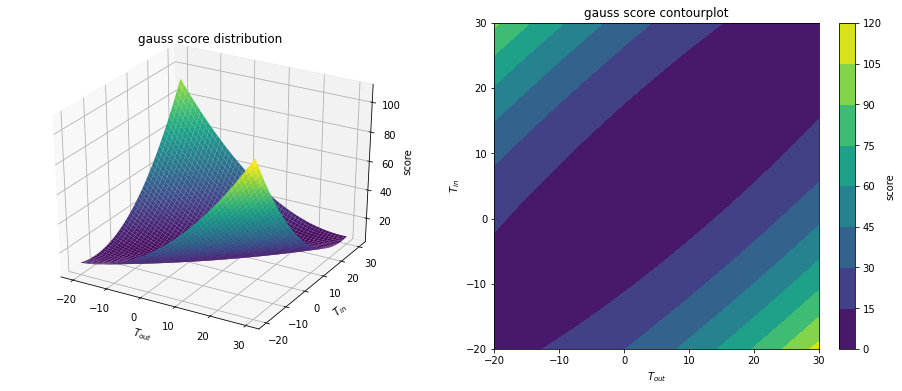

In [ ]:
# Show R_gauss

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Grid
x = np.linspace(-20, 30, 500)
y = np.linspace(-20, 30, 500)
X, Y = np.meshgrid(x,y)

# Multivariate Normal
mu_x = np.mean(x)
sigma_x = np.std(x)
mu_y = np.mean(y)
sigma_y = np.std(y)
rv = multivariate_normal([7.347071732125886, 9.112060973913035], [[88.00106814, 71.62624662], [71.62624662, 69.42929521]])

# Probability Density
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
pdf= np.log(1./rv.pdf(pos))
#pd = np.max(rv.pdf(pos))-rv.pdf(pos)

# Plot
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_surface(X, Y, pdf, cmap='viridis', linewidth=0)
ax.set_xlabel(r'$T_{out}$')
ax.set_ylabel(r'$T_{in}$')
ax.set_zlabel('score')
plt.title("gauss score distribution")

ax2 = fig.add_subplot(1,2,2)
CS = ax2.contourf(X, Y, pdf, cmap=cm.viridis)
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('score')

ax2.set_xlabel(r'$T_{out}$')
ax2.set_ylabel(r'$T_{in}$')
ax2.set_title('gauss score contourplot')
plt.show()

In [ ]:
from scipy.stats import multivariate_normal

def gauss_score(dl3,dl1):
    # mean, standard deviation matrix estimated from the data (notebook 1)
    mi = np.array([7.347071732125886, 9.112060973913035])
    sigma = np.array([[88.00106814, 71.62624662], [71.62624662, 69.42929521]])
    pdf = multivariate_normal(mi,sigma)
    max = pdf.pdf(mi)
    score = 0
    for (tout, tin) in zip(dl3,dl1):
        score += -np.log(pdf.pdf((tout,tin)))/len(dl1)
    return score

def l2_score(dlo, dlr):
  # dlo: vector of original variables, dlr: vector of reconstructed variables
  return np.linalg.norm(dlo[:len(dlr)] - dlr)/len(dlo)

## Simple controlled task: sine wave reconstruction

Fist of all we applied a simple VAE architecture to synthetically generated data that resembled a simplified ideal version of our real dataset: the sum of two sin waves, one with the periodicity of the year and the other with the periodicity of the day. 

In [ ]:
# building dataset: 2 sinwaves + noise
from math import pi

def sample_wave(t):
  ''' Simulate a natural climate by adding two periodic waves (year+day) and noise '''
  return 0.8*np.sin(t*2*pi/365)+0.2*np.sin(t*2*pi)+0.5*np.random.random_sample(size = t.size)

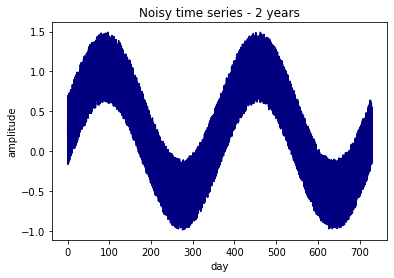

In [ ]:
t = np.arange(0,365*2,0.02)
x = sample_wave(t)
plt.plot(t, x, color='navy')
plt.xlabel('day')
plt.ylabel('amplitude')
plt.title('Noisy time series - 2 years')
theta_year = (np.sin(t*2*pi/365))
theta_day = (np.sin(t*2*pi))
# test set
t_test = np.arange(0,365*2,0.02)
x_test = sample_wave(t_test)

In [ ]:
# Reshape 
nr_days = 365*2
nr_stamps = 50
x_days = x.reshape(nr_days, nr_stamps, 1)
x_test = x_test.reshape(nr_days, nr_stamps, 1)

theta_year = theta_year.reshape(nr_days, nr_stamps, 1)
theta_day = theta_day.reshape(nr_days, nr_stamps, 1)

x_train = np.append(theta_year, x_days, axis=2)
x_train = np.append(x_train, theta_day, axis=2)
x_test = np.append(theta_year, x_test, axis=2)
x_test = np.append(x_test, theta_day, axis=2)

input_shape = (nr_stamps, 3)

# Standardize data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
x_train[:,:,2] = scaler.fit_transform(x_train[:,:,2])

test_scalers = []
scaler = StandardScaler()
x_test[:,:,2] = scaler.fit_transform(x_test[:,:,2])

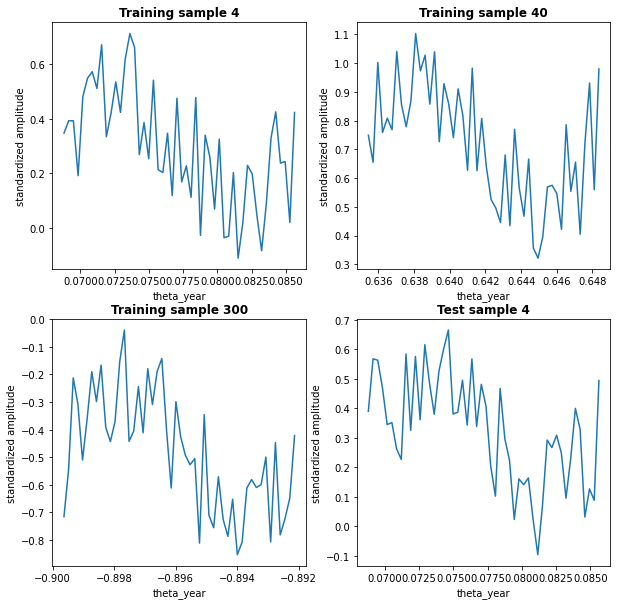

In [ ]:
# View a few sequences
plt.figure(1,  figsize=(10,10))
plt.subplot(221)
plt.plot(x_train[4,:,0], x_train[4,:,1])
plt.title('Training sample 4', fontweight='bold')
plt.xlabel('theta_year')
plt.ylabel('standardized amplitude')

plt.subplot(222)
plt.plot(x_train[40,:,0], x_train[40,:,1])
plt.title('Training sample 40', fontweight='bold')
plt.xlabel('theta_year')
plt.ylabel('standardized amplitude')

plt.subplot(223)
plt.plot(x_train[300,:,0], x_train[300,:,1])
plt.title('Training sample 300', fontweight='bold')
plt.xlabel('theta_year')
plt.ylabel('standardized amplitude')

plt.subplot(224)
plt.plot(x_test[4,:,0], x_test[4,:,1])
plt.title('Test sample 4', fontweight='bold')
plt.xlabel('theta_year')
plt.ylabel('standardized amplitude')
plt.show()

As one can see, the sinusoidal pattern is subtle and mostly corrupted by noise. Convolutional layers seem possibly the best way to retrieve the macro sinusoidal features and drop the noise, for that reason we implement them in the encoder. since the model is simple, just 2 latent dimensions are enought to represent it. By enlarging this parameter instead also the noise is learnt.

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 12)       372         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 25, 12)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 16, 12)       1452        max_pooling1d[0][0]              
____________________________________________________________________________________________

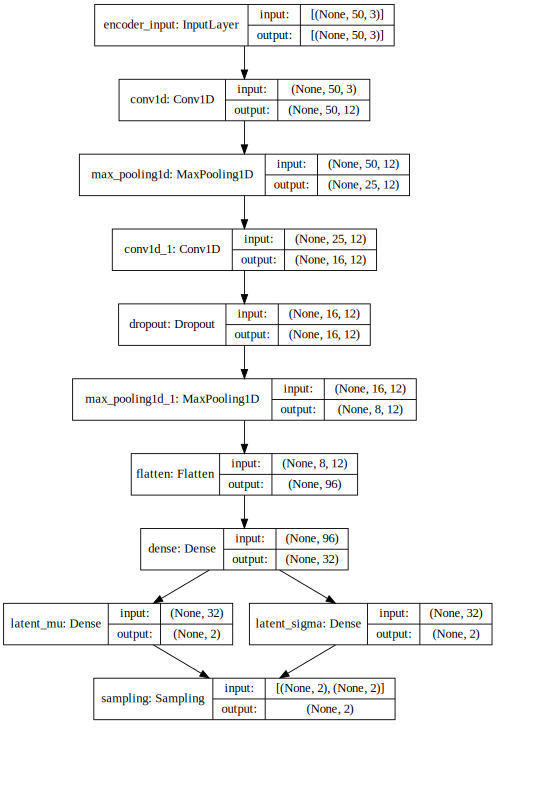

In [ ]:
latent_dim = 2 # Number of latent dim parameters

encoder_input = layers.Input(shape=input_shape, name='encoder_input')
x = layers.Conv1D(12, 10, padding='same', activation='elu')(encoder_input)
x = layers.MaxPool1D(pool_size=2)(x)
x = layers.Conv1D(12,10, activation="elu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPool1D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='elu')(x)
z_mean = layers.Dense(latent_dim, name='latent_mu')(x)
z_log_var = layers.Dense(latent_dim, name='latent_sigma')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
SVG(model_to_dot(encoder, show_shapes= True, show_layer_names=True,  dpi=65).create(prog='dot', format='svg'))

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 600)               19800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 12)            0         
_________________________________________________________________
decoder_output (Conv1DTransp (None, 50, 3)             111       
Total params: 20,007
Trainable params: 20,007
Non-trainable params: 0
_______________________________________________________

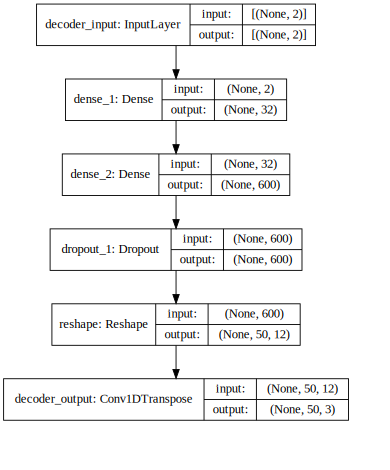

In [ ]:
# Decoder

decoder_input = layers.Input(shape=(latent_dim, ), name='decoder_input')
x = layers.Dense(32, activation='elu')(decoder_input)
x = layers.Dense(600, activation='elu')(x)
x = layers.Dropout(0.2)(x)
# reshape to the shape of last conv. layer in the encoder
x = layers.Reshape((50, 12))(x)
x = layers.Conv1DTranspose(3, 3, padding='same',
                           name='decoder_output')(x)
# Define and summarize decoder model
decoder = keras.Model(decoder_input, x, name='decoder')
decoder.summary()
SVG(model_to_dot(decoder, show_shapes= True, show_layer_names=True,  dpi=65).create(prog='dot', format='svg'))

In [ ]:
vae = VAE(encoder, decoder, beta=500)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs = 50, batch_size = 32)

Epoch 1/50
23/23 [==============================] - 40s 7ms/step - loss: 1575.1217 - reconstruction_loss: 1512.4292 - kl_loss: 49.7726
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 1521.9904 - reconstruction_loss: 1438.8344 - kl_loss: 42.2018
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 1393.9546 - reconstruction_loss: 1181.4357 - kl_loss: 183.8416
Epoch 4/50
23/23 [==============================] - 0s 4ms/step - loss: 1279.0411 - reconstruction_loss: 1024.8186 - kl_loss: 235.2743
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 1315.1010 - reconstruction_loss: 1027.7968 - kl_loss: 249.2857
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 1308.7203 - reconstruction_loss: 999.4928 - kl_loss: 264.3732
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 1271.1837 - reconstruction_loss: 987.5076 - kl_loss: 269.0301
Epoch 8/50
23/23 [==============================] - 0s 3ms

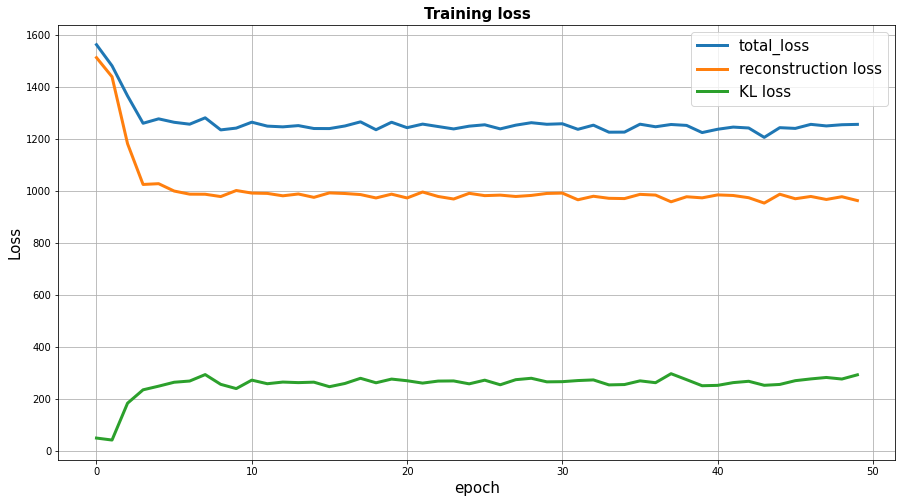

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'], label="total_loss", lw=3)
plt.plot(history.history['reconstruction_loss'], label="reconstruction loss", lw=3)
plt.plot(history.history['kl_loss'], label="KL loss", lw=3)
plt.title("Training loss", size=15, fontweight="bold")
plt.xlabel("epoch", size=15)
plt.ylabel("Loss", size=15)
plt.legend(loc="best", fontsize=15)
plt.grid()

Here and also in the next training loss plots we can see that the two terms of the loss are of different orders of magnitude, even though the KL divergence has been multiplied for a beta of 600, and also that it tends to increase during the first few epochs and then it stabilizes. We have found empyrically that the KL divergence functions as a regularizer in this case and also that enlarging too much beta has nasty consequences: the reconstruction becomes overly simplified.

The plot below shows either the $\mu$ and $\log (\sigma)$ parameters of the posterior distribution computed for each training sample and the corresponding sampling of latent variables. The points' color represents the timestamp (from 0 to 365).

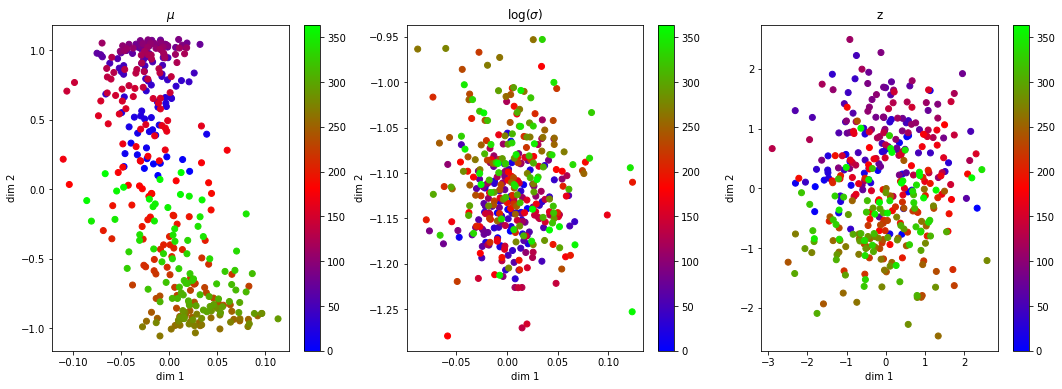

In [ ]:
# Visualize results

#Visualize inputs mapped to the Latent space

mu, sigma, z = encoder.predict(x_test[:365])
#Plot dim1 and dim2 for mu
plt.figure(1, figsize=(18,6))
plt.subplot(131)
plt.scatter(mu[:, 0], mu[:, 1], c=np.arange(0,len(mu),1), cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(r'$\mu$')
plt.colorbar()

plt.subplot(132)
plt.scatter(sigma[:, 0], sigma[:, 1], c=np.arange(0,len(sigma),1), cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(r'log($\sigma$)')
plt.colorbar()

plt.subplot(133)
plt.scatter(z[:, 0], z[:, 1], c=np.arange(0,len(z),1), cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title('z')
plt.colorbar()
plt.show()

In the latent space of the mean we can see some kind of periodicity: blue and green dots populate different areas and seem to reconnect following the periodicity of the year.

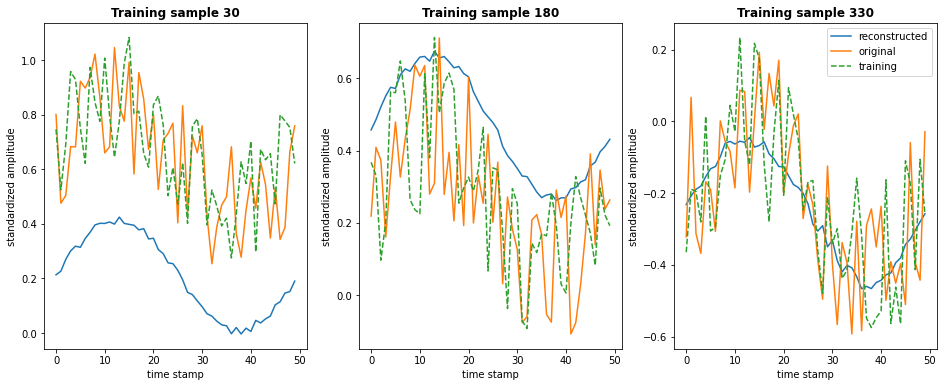

In [ ]:
z_0 = np.array([[z[30,0], z[30,1]]])
decoded_sample = decoder.predict(z_0)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax[0].plot(decoded_sample[0,:,1], label='reconstructed')
ax[0].plot(x_test[30,:,1], label='original')
ax[0].plot(x_train[30,:,1],'--', label='training')
ax[0].set_title('Training sample 30', fontweight='bold')
ax[0].set_xlabel('time stamp')
ax[0].set_ylabel('standardized amplitude')

z_30 = np.array([[z[180,0], z[180,1]]])
decoded_sample = decoder.predict(z_30)
ax[1].plot(decoded_sample[0,:,1], label='reconstructed')
ax[1].plot(x_test[180,:,1], label='original')
ax[1].plot(x_train[180,:,1],'--', label='training')
ax[1].set_title('Training sample 180', fontweight='bold')
ax[1].set_xlabel('time stamp')
ax[1].set_ylabel('standardized amplitude')

z_90 = np.array([[z[330,0], z[330,1]]])
decoded_sample = decoder.predict(z_90)
ax[2].plot(decoded_sample[0,:,1], label='reconstructed')
ax[2].plot(x_test[330,:,1], label='original')
ax[2].plot(x_train[330,:,1],'--', label='training')
ax[2].set_title('Training sample 330', fontweight='bold')
ax[2].set_xlabel('time stamp')
ax[2].set_ylabel('standardized amplitude')
plt.legend()
plt.show()

From the previous plots it can be noticed that the VAE is succesful in learning the sinusoidal tendence and also in denoising since it produces a smooth pattern. Even so, it is not an ideal denoiser since it doesn't manage to always reconstruct the correct amplitudes sizes.

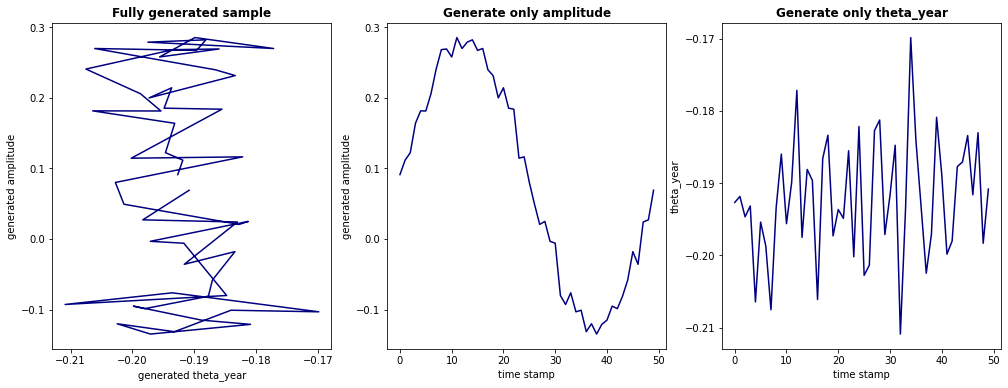

In [ ]:
# Sampling from the latent space
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,6))
sample_vector = np.array([[-1.05,-0.28]])
decoded_example = decoder.predict(sample_vector)
ax[0].plot(decoded_example[0,:,0], decoded_example[0,:,1], color='navy')
ax[0].set_title('Fully generated sample', fontweight='bold')
ax[0].set_xlabel('generated theta_year')
ax[0].set_ylabel('generated amplitude')
ax[1].plot(decoded_example[0,:,1], color='navy')
ax[1].set_title('Generate only amplitude', fontweight='bold')
ax[1].set_xlabel('time stamp')
ax[1].set_ylabel('generated amplitude')
ax[2].plot(decoded_example[0,:,0], color='navy')
ax[2].set_title('Generate only theta_year', fontweight='bold')
ax[2].set_ylabel('theta_year')
ax[2].set_xlabel('time stamp')
plt.show()

From the first plot we can see that if we sample a time sequence from the latent space we do not get what we would expect: it is due to the fact that the VAE doesn't reconstruct properly the temporal parameter. From the second plot we see that insted it does a nice job on the signal reconstruction, given that we provide the temporal variable.

## Ringebu dataset

### Data preparation

The use of the Convolutional layers allows to inspect local patterns of the dataset, so we decided to split the dataset in a way such that each subsample contains information of one week time period. In this way it is possible to analyze 1 day long batches and, in doing so, to find the daily periodicity.

The choice of 7 days was adopted even to decect eventual weekly patterns, such as Sunday's celebration.

In [7]:
n_days = 7                          # each sample is made of n_days days
stride = 1                          # number of days to skip between two samples
day_records = 288                   # records in one day
n_records = n_days * day_records
n_features = 8
n_steps = int((365 - n_days) / stride)
first_date = pd.to_datetime("2014-03-30 06:00:00")

In order to give some explicit temporal informations to the VAE, we attached to the first 4 columns of the dataset (which contain rispectively the internal Humidity $H_{int}$, internal Temperature $T_{int}$, external Humidity $H_{ext}$ and external Temperature $T_{ext}$), 4 more columns containing respectively:
 

*   The sine of the number of seconds from the first day of the year normalized over the total number of seconds in one year $\sin_{y}=\sin(\frac{\text{# sec. from Jan 1}}{60 \cdot 60 \cdot 24 \cdot 365}2\pi)$
*   The cosine of the number of seconds from the first day of the year normalized over the total number of seconds in one year $\cos_{y}=\cos(\frac{\text{# sec. from Jan 1}}{60 \cdot 60 \cdot 24 \cdot 365}2\pi)$
*   The sine of the number of seconds from the previous midnight normalized over the total number of seconds in one day $\sin_{d}=\sin(\frac{\text{# sec. from 00:00:00}}{60 \cdot 60 \cdot 24}2\pi)$
*   The cosine of the number of seconds from the previous midnight normalized over the total number of seconds in one day $\cos_{d}=\cos(\frac{\text{# sec. from 00:00:00}}{60 \cdot 60 \cdot 24}2\pi)$


This information helps the VAE to recognize the different periods of the day and year, and spot a periodic pattern to encode in the latent space.

In [8]:
def get_year(df):
    """Return a ndarray with sets of n_days days, according to the stride parameter"""
    data_year = np.ndarray(shape=(0, n_records, n_features))
    tot_days = int(df.shape[0]*5/(60*24))
    n_steps = int((tot_days - n_days) / stride)
    for i in range(n_steps):
        bunch = df.iloc[i*stride*day_records : i*stride*day_records + n_records]
        diff_days = (bunch.index - first_date).total_seconds().to_numpy() / (60*60*24)
        omega_year = 2*np.pi / 365
        sin_year, cos_year = np.sin(omega_year*diff_days).reshape((-1, 1)), np.cos(omega_year*diff_days).reshape(-1, 1)
        hours = bunch.index.hour.to_numpy()
        omega_day = 2*np.pi / 24
        sin_hours, cos_hours = np.sin(omega_day*hours).reshape((-1, 1)), np.cos(omega_day*hours).reshape((-1, 1))
        payload = np.hstack((bunch.values, sin_hours, cos_hours, sin_year, cos_year))
        data_year = np.append(data_year, [payload], axis=0)
    return data_year

def import_ringebu_generation_set(Rdf):
    """Import the Ringebu dataset and slice it as in 'get_year'.
    Furthenmore, return a ndarray with the position of each row -> useful
    for average over repeated data"""
    positions = np.arange(Rdf.shape[0]) # needed to average over generated samples
    data_year = np.ndarray(shape=(0, n_records, n_features))
    pos_slices = np.ndarray(shape=(0, n_records), dtype="int32")
    tot_days = int(Rdf.shape[0]*5/(60*24))
    n_steps = int((tot_days - n_days) / stride)
    for i in range(n_steps):
        bunch = Rdf.iloc[i*stride*day_records : i*stride*day_records + n_records]
        bunch_pos = positions[i*stride*day_records : i*stride*day_records + n_records]
        diff_days = (bunch.index - first_date).total_seconds().to_numpy() / (60*60*24)
        omega_year = 2*np.pi / 365
        sin_year, cos_year = np.sin(omega_year*diff_days).reshape((-1, 1)), np.cos(omega_year*diff_days).reshape(-1, 1)
        hours = bunch.index.hour.to_numpy()
        omega_day = 2*np.pi / 24
        sin_hours, cos_hours = np.sin(omega_day*hours).reshape((-1, 1)), np.cos(omega_day*hours).reshape((-1, 1))
        payload = np.hstack((bunch.values, sin_hours, cos_hours, sin_year, cos_year))
        data_year = np.append(data_year, [payload], axis=0)
        pos_slices = np.append(pos_slices, [bunch_pos], axis=0)    
    return (data_year, pos_slices)

In [ ]:
X_train = get_year(pd.read_csv("Reconstructed_dataset.csv", index_col="date", parse_dates=True, dtype="float32")) # Train data from stations
ringebu_df = pd.read_csv("Ringebu.csv", index_col=0, parse_dates=True, dtype="float32")                      # Ringebu dataset to be denoised
start_index = np.where(ringebu_df.index=='2019-03-31 06:00:00')[0][0]
ringebu_df = ringebu_df[start_index:]
ringebu_cut_df = pd.read_csv("Ringebu_cut_lorenzo.csv", index_col=0, parse_dates=True, dtype="float32")      # Ringebu dataset with some cuts
ringebu_cut_df = ringebu_cut_df[start_index:]
X_ringebu, pos_ringebu = import_ringebu_generation_set(ringebu_df)
X_ringebu_cut, pos_ringebu_cut = import_ringebu_generation_set(ringebu_cut_df)
print(f"Train set size:", X_train.shape)
print(f"Ringebu set size:", X_ringebu.shape)

In [ ]:
!ls

Natural-climate-reconstruction-with-VAE  sample_data


[Errno 2] No such file or directory: 'Natural-climate-reconstruction-with-VAE/data'
/content/Natural-climate-reconstruction-with-VAE
